# DOE 本番解析用

In [23]:
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import griddata
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import ols

### Matplotlib の設定（オプション）

In [24]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 14

## CSV ファイルの読込

In [25]:
# データ読み込み
path_dir = "../output/doe-1/7011"
list_file = sorted(os.listdir(path_dir))
print(list_file)
list_df = list()
for file in list_file:
    path = os.path.join(path_dir, file)
    list_df.append(pd.read_csv(path))
print(f"\nn = {len(list_df)}")
df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df

['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv', 'ticks_20250925.csv', 'ticks_20250926.csv', 'ticks_20250929.csv', 'ticks_20250930.csv', 'ticks_20251001.csv', 'ticks_20251006.csv', 'ticks_20251007.csv', 'ticks_20251008.csv', 'ticks_20251009.csv', 'ticks_20251010.csv', 'ticks_20251014.csv', 'ticks_20251015.csv', 'ticks_20251016.csv', 'ticks_20251017.csv', 'ticks_20251020.csv', 'ticks_20251021.csv', 'ticks_20251022.csv', 'ticks_20251023.csv', 'ticks_20251024.csv', 'ticks_20251027.csv', 'ticks_20

,file,code,trade,PERIOD_MA_1,PERIOD_MA_2,PERIOD_MR,THRESHOLD_MR,total
0,ticks_20250819.xlsx,7011,100,30,300,15,1,32.0
1,ticks_20250819.xlsx,7011,100,60,300,15,1,59.0
2,ticks_20250819.xlsx,7011,100,90,300,15,1,62.0
3,ticks_20250819.xlsx,7011,100,30,600,15,1,26.0
4,ticks_20250819.xlsx,7011,82,60,600,15,1,109.0
...,...,...,...,...,...,...,...,...
5665,ticks_20251203.xlsx,7011,12,60,600,45,7,-38.0
5666,ticks_20251203.xlsx,7011,12,90,600,45,7,-8.0
5667,ticks_20251203.xlsx,7011,20,30,900,45,7,-41.0
5668,ticks_20251203.xlsx,7011,14,60,900,45,7,-34.0


## 分散分析 (ANOVA)

In [26]:
# オリジナルのデータフレームをコピーして利用
df_anova = df.copy()

# 因子列と応答変数
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "PERIOD_MR", "THRESHOLD_MR"]
X = df_anova[factor_cols]
y = df_anova["total"]

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=factor_cols)

# 標準化した因子を df に置き換え
for col in factor_cols:
    df_anova[col] = X_scaled_df[col]

# 二次交互作用まで含めるモデル
"""
formula = (
    "total ~ PERIOD_MA_1 + PERIOD_MA_2 + PERIOD_MR + THRESHOLD_MR "
    "+ PERIOD_MA_1:PERIOD_MA_2 + PERIOD_MA_1:PERIOD_MR + PERIOD_MA_1:THRESHOLD_MR "
    "+ PERIOD_MA_2:PERIOD_MR + PERIOD_MA_2:THRESHOLD_MR + PERIOD_MR:THRESHOLD_MR"
)
"""
formula = (
    "total ~ PERIOD_MA_1 + PERIOD_MA_2 + PERIOD_MR + THRESHOLD_MR "
    "+ PERIOD_MA_1:PERIOD_MA_2 + PERIOD_MR:THRESHOLD_MR"
)
model_2way = ols(formula, data=df_anova).fit()

# ANOVAテーブル
anova_table = sm.stats.anova_lm(model_2way, typ=2)
print("=== ANOVA (up to 2-way interactions) ===")
print(anova_table)

=== ANOVA (up to 2-way interactions) ===
                               sum_sq      df          F    PR(>F)
PERIOD_MA_1              1.098795e+03     1.0   0.263465  0.607770
PERIOD_MA_2              1.603339e+04     1.0   3.844427  0.049961
PERIOD_MR                5.455280e+02     1.0   0.130805  0.717613
THRESHOLD_MR             4.379205e+04     1.0  10.500295  0.001200
PERIOD_MA_1:PERIOD_MA_2  5.520992e+03     1.0   1.323803  0.249959
PERIOD_MR:THRESHOLD_MR   1.676587e+00     1.0   0.000402  0.984004
Residual                 2.361785e+07  5663.0        NaN       NaN


## 主効果＋交互作用 プロット

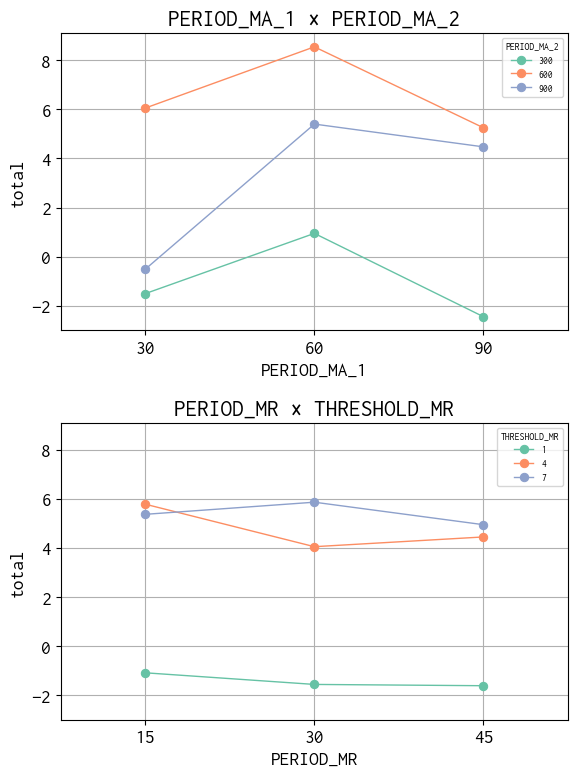

In [27]:
#output = os.path.join("..", "logs", "doe_effects.png")

pairs = [
    ("PERIOD_MA_1", "PERIOD_MA_2"),
    ("PERIOD_MR", "THRESHOLD_MR"),
]
n = len(pairs)
fig, ax = plt.subplots(len(pairs), 1, figsize=(6, n * 4))
y_min_all = 1e6
y_max_all = -1e6
for i, (a, b) in enumerate(pairs):
    sns.pointplot(
        x=a,
        y="total",
        hue=b,
        data=df,
        markersize=6,
        linewidth=1,
        errorbar=None,
        palette="Set2",
        ax=ax[i],
    )
    ax[i].set_title(f"{a} × {b}")
    ax[i].set_xlabel(a)
    ax[i].set_ylabel("total")
    lg = ax[i].legend(fontsize=7)
    lg.set_title(b, prop={"size": 7})
    ax[i].grid()
    y_min, y_max = ax[i].get_ylim()
    if y_min < y_min_all:
        y_min_all = y_min
    if y_max_all < y_max:
        y_max_all = y_max

for i in range(n):
    ax[i].set_ylim(y_min_all, y_max_all)

plt.tight_layout()
#plt.savefig(output)
plt.show()

## 交互作用の等高線図

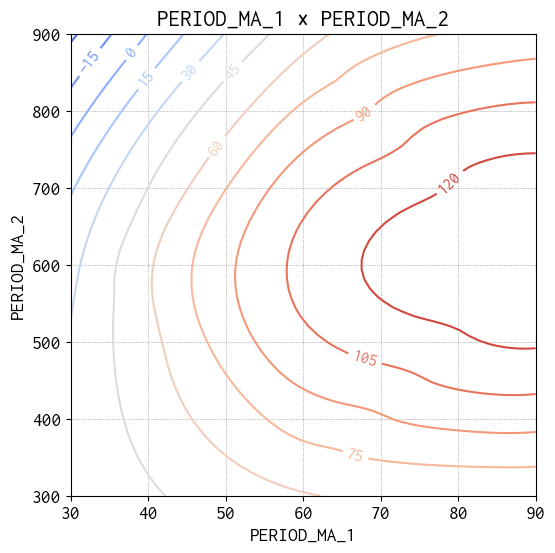

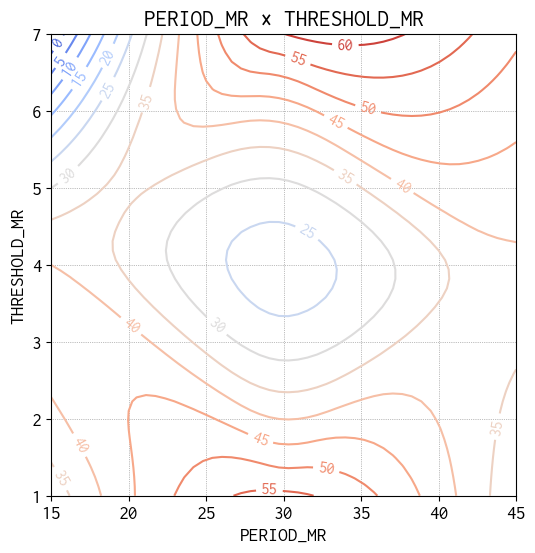

In [28]:
def plot_contour(col_x: str, col_y: str, col_z: str, output: str = ""):
    x = df[col_x]
    y = df[col_y]
    z = df[col_z]

    # グリッド作成
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    Xi, Yi = np.meshgrid(xi, yi)
    # 補間
    Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

    plt.figure(figsize=(6, 6))
    cont = plt.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm")
    plt.clabel(cont, inline=True, fontsize=12)
    plt.title(f"{col_x} × {col_y}")
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.grid(True, color="gray", linestyle="dotted", linewidth=0.5)
    # plt.savefig(output)
    plt.show()


# ===== 1. PERIOD_MA_1 × PERIOD_MA_2 =====
output = ""
# output = os.path.join("..", "logs", f"{file_body}_contour_1.png")
plot_contour("PERIOD_MA_1", "PERIOD_MA_2", "total", output)
# ===== 2. PERIOD_MR × THRESHOLD_MR =====
# output = os.path.join("..", "logs", f"{file_body}_contour_2.png")
plot_contour("PERIOD_MR", "THRESHOLD_MR", "total", output)

## 二次多項式と Lasso 回帰

In [29]:
# 1. 因子を数値として扱う
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "PERIOD_MR", "THRESHOLD_MR"]
X = df[factor_cols]
y = df["total"]

# 2. 二次回帰＋Lasso
poly = PolynomialFeatures(degree=2, include_bias=False)
lasso = LassoCV(cv=5, random_state=0)

model = make_pipeline(poly, lasso).fit(X, y)

# 3. サマリ統計
# 展開後の特徴量名を取得
feature_names = poly.get_feature_names_out(factor_cols)

# 係数を取り出し
coef = model.named_steps["lassocv"].coef_

# 結果をDataFrameにまとめる
summary = pd.DataFrame({"feature": feature_names, "coefficient": coef})

# 非ゼロ係数のみ表示
summary_nonzero = summary[summary["coefficient"] != 0]

print("=== Lassoによる選択結果（非ゼロ係数） ===")
print(summary_nonzero)

# モデル性能
y_pred = model.predict(X)
print("\nR^2:", r2_score(y, y_pred))
print("Best alpha (正則化パラメータ):", model.named_steps["lassocv"].alpha_)

=== Lassoによる選択結果（非ゼロ係数） ===
Empty DataFrame
Columns: [feature, coefficient]
Index: []

R^2: 0.0
Best alpha (正則化パラメータ): 383232.8042328044
